In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

In [3]:
data = np.genfromtxt('/Users/tikitorch/Desktop/shortrangesinglet.csv', delimiter=',', skip_header=1)

ranges = data[:,0]
singlet = data[:,1]

interp_func = interp1d(ranges, singlet, kind = 'linear', fill_value = 'extrapolate')
def singlet(rho):
    return (interp_func(rho / 2.69e-3) + 1) * 27.2114
new_ranges = np.linspace(.45, 10, 100) * 2.69e-3

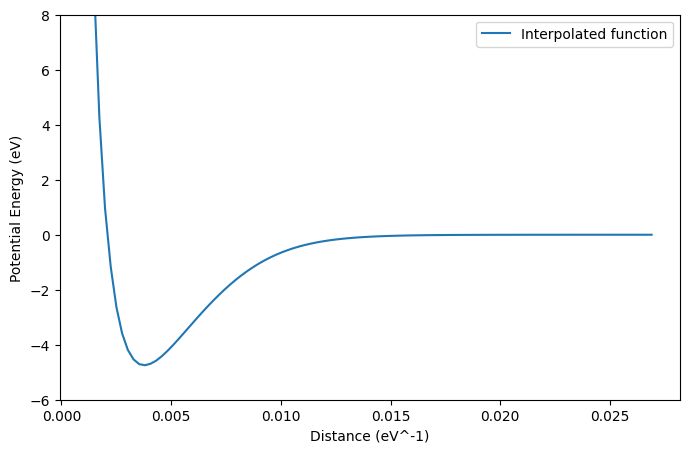

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(new_ranges, singlet(new_ranges), label='Interpolated function')
plt.xlabel('Distance (eV^-1)')
plt.ylabel('Potential Energy (eV)')
plt.ylim(-6,8)
plt.legend()
plt.show()

In [5]:
def p_of_temp(mu, T):
    J2eV = 6.242e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

print(p_of_temp(469.39e6, 5e-4))

6.360195131058968


In [6]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]

def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 2000)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return np.sqrt(2/np.pi) * State.y[0]/Normalization[-1]

def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 1000)
    init = [r0,1]
    
    State = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    deltas = np.arctan(p * State / Statedev) - p * rhos
    return deltas[-1]

In [7]:
bigrhos = np.linspace(.01,.0269, 10)
phases = []
for bigrho in bigrhos:
    phase = GetPhaseShift(bigrho, 6, 0, .00012, 469.39e6, singlet, 'Radau')
    phases.append(phase)
phases = np.array(phases)

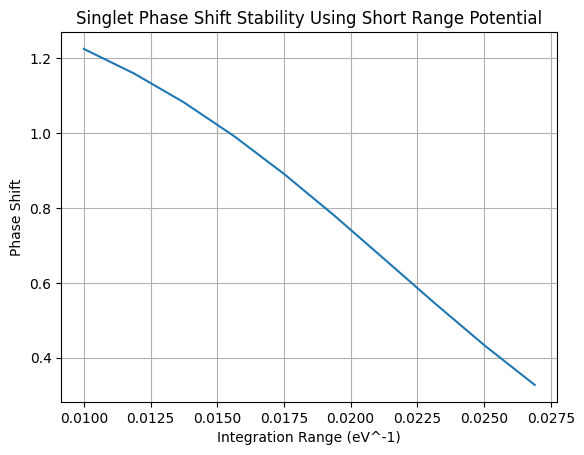

In [8]:
plt.plot(bigrhos,phases)
plt.xlabel("Integration Range (eV^-1)")
plt.ylabel("Phase Shift")
plt.title("Singlet Phase Shift Stability Using Short Range Potential")
plt.grid(True)
plt.show()

In [9]:
def Silvera_Triplet(R):
    conv = 5.06e-4
    x = R / conv / 4.16 
    D = 1.28
    K2eV = 8.61732814974056e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

In [12]:
phasestwo =[]
bigrhostwo = np.linspace(.01,100,100)
for bigrho in bigrhostwo:
    phase = GetPhaseShift(bigrho, 6, 0, .00012, 469.39e6, Silvera_Triplet, 'Radau')
    phasestwo.append(phase)
phasestwo = np.array(phasestwo)

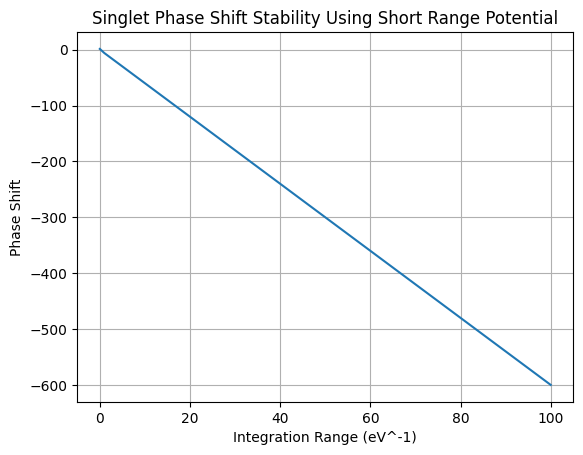

In [13]:
plt.plot(bigrhostwo,phasestwo)
plt.xlabel("Integration Range (eV^-1)")
plt.ylabel("Phase Shift")
plt.title("Singlet Phase Shift Stability Using Short Range Potential")
plt.grid(True)
plt.show()

In [16]:
def GetSpatials(mu, vals):
    aaSpatials = []
    for A in vals:
        r0 = 1e-9
        P = 6
        const = np.pi / (mu * P)

        tdelta = GetPhaseShift(A, P, 0, r0, mu, Silvera_Triplet, 'Radau')
        sdelta = GetPhaseShift(A, P, 0, r0, mu, singlet, 'Radau')
        aaSpatials.append(const * np.sin(tdelta-sdelta)**2)
    aaSpatials = np.array(aaSpatials)
    return aaSpatials
Hmu = 469.39e6
Bigrhos = np.linspace(.01, .0269, 30)
Spatials = GetSpatials(Hmu, Bigrhos)

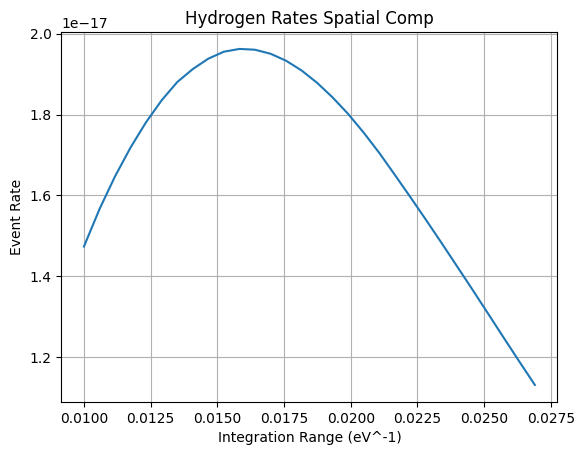

In [19]:
plt.plot(Bigrhos,Spatials)
plt.xlabel("Integration Range (eV^-1)")
plt.ylabel("Event Rate")
plt.title("Hydrogen Rates Spatial Comp")
plt.grid(True)
plt.show()